In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import sys
import os
import random

In [3]:
def load_images(img_dir, img_names):
    image_refs_out = {}
    crops_out = {}
    
    w = 2160 / 2
    for img_name in img_names:
        path = img_dir + '/{}/images/undistorted'.format(img_name)
        img_paths = sorted(glob.glob(path + '/*.jpg'))
        image_refs_undistort = []
        for i, path in enumerate(img_paths):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
            image_refs_undistort.append(img)

        image_refs_cropped = []
        for i in range(len(image_refs_undistort)):
            image = image_refs_undistort[i]
            cx = image.shape[1] / 2

            image = image_refs_undistort[i]
            img = image[:, int(cx-w):int(cx+w)]
            img = cv2.resize(img, (image_size, image_size))
            image_refs_cropped.append(img)
        image_refs_out[img_name] = image_refs_undistort
        crops_out[img_name] = image_refs_cropped
    return image_refs_out, crops_out
def load_clean_plates(img_dir):
    img_paths = sorted(glob.glob(img_dir + '/*.PNG'))
    images0 = []
    images_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        images0.append(img)
        images_undistort.append(img)

    w = 2160 / 2
    clean_plates_cropped = []
    for i in range(len(images_undistort)):
        image = images_undistort[i]
        cx = image.shape[1] / 2

        image = images_undistort[i].astype(np.float32)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        # img = np.dstack([img, img, img])
        clean_plates_cropped.append(img)
    
    return images0, images_undistort, clean_plates_cropped 

In [4]:
clean_plate_dir = r'D:\Pictures\2019_12_13_Lada_Capture\CleanPlates\undistorted'
img_dir = './9_data/input'
#img_names = ['03052', '03990', '04917', '06950']
img_names = ['03052']
image_size = 1080

In [5]:
img_refs_undistorted, img_refs = load_images(img_dir, img_names)
print('img_refs_undistorted:', img_refs_undistorted.keys())
print('  {}'.format(img_refs_undistorted[list(img_refs_undistorted.keys())[0]][0].shape))
print('img_refs:', img_refs.keys())
print('  {}'.format(img_refs[list(img_refs.keys())[0]][0].shape))

clean_plates_original, clean_plates_undistort, clean_plates = load_clean_plates(clean_plate_dir)
print('clean_plates_original:', clean_plates_original[0].shape)

img_refs_undistorted: dict_keys(['03052'])
  (2160, 4000)
img_refs: dict_keys(['03052'])
  (1080, 1080)
clean_plates_original: (2160, 4000)


In [6]:
print(img_refs.keys())
print(len(clean_plates))
image_refs = []

dict_keys(['03052'])
16


# Setting

In [84]:
cam_idx = 8
image_name = '03052'

src = img_refs[image_name][cam_idx]
src = (src*255.0).astype(np.uint8)
src = np.dstack([src, src, src])
print(src.shape, src.dtype, np.max(src))

(1080, 1080, 3) uint8 255


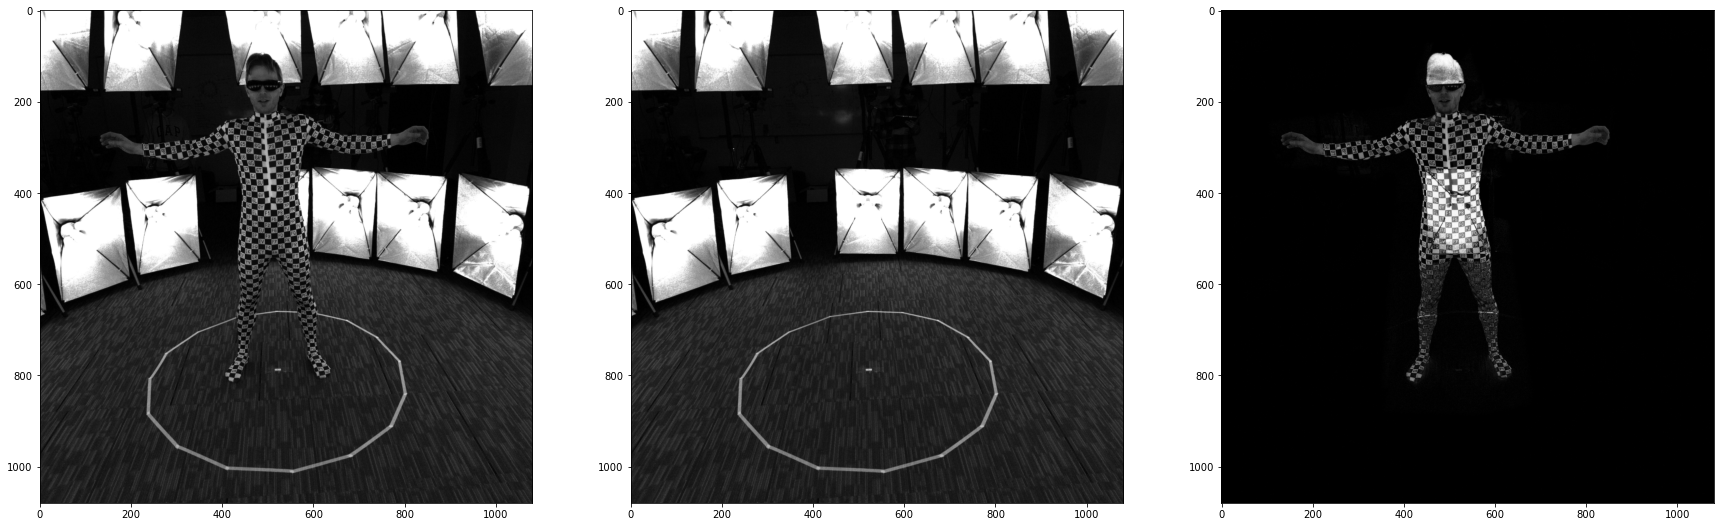

In [85]:
img = img_refs[image_name][cam_idx]
bg = clean_plates[cam_idx]
diff = img-bg
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(bg, cmap='gray')
ax[2].imshow(np.abs(diff), cmap='gray')
plt.show()

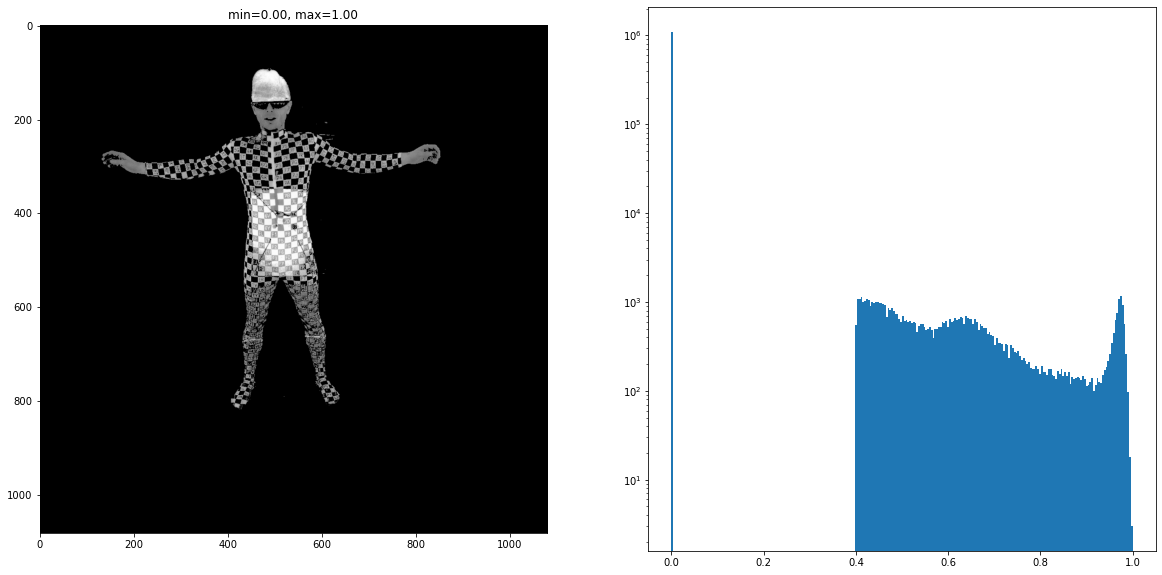

In [199]:
diff2 = np.abs(diff)
diff2 = (diff2 - np.min(diff2)) / (np.max(diff2) - np.min(diff2))
diff2 = np.where(diff2 > 0.1, diff2+0.5, 0)
diff2 = (diff2 - np.min(diff2)) / (np.max(diff2) - np.min(diff2))
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(diff2, cmap='gray')
ax[0].set_title('min={:.2f}, max={:.2f}'.format(np.min(diff2), np.max(diff2)))

ax[1].hist(diff2.ravel(), 256)
ax[1].set_yscale('log')
plt.show()

# Semgentation

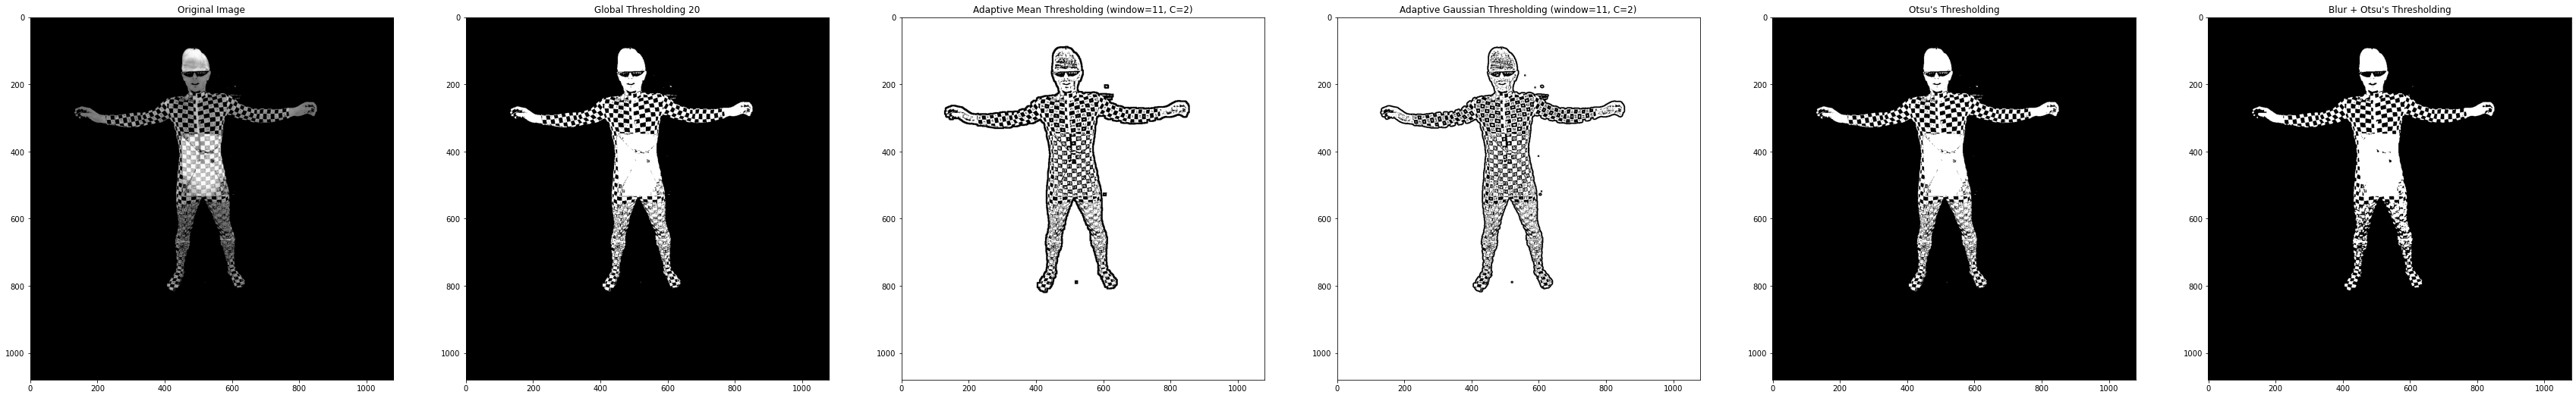

In [204]:
# img = cv2.medianBlur((diff2*255.0).astype(np.uint8), 3)
img = (diff2*255.0).astype(np.uint8)

thres_val = 20
# global thresholding
ret1,th1 = cv2.threshold(img, thres_val, 255, cv2.THRESH_BINARY)
# adaptive mean
win_size = 11
minus_C = 2
th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, win_size, minus_C)
# adaptive gaussian
th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, win_size, minus_C)
# Otsu's thresholding
ret4, th4 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret5, th5 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

titles = ['Original Image', 'Global Thresholding {}'.format(thres_val), 'Adaptive Mean Thresholding (window={}, C={})'.format(win_size, minus_C), 'Adaptive Gaussian Thresholding (window={}, C={})'.format(win_size, minus_C), "Otsu's Thresholding", "Blur + Otsu's Thresholding"]
images = [img, th1, th2, th3, th4, th5]

fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 10))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(titles[i])
plt.show()

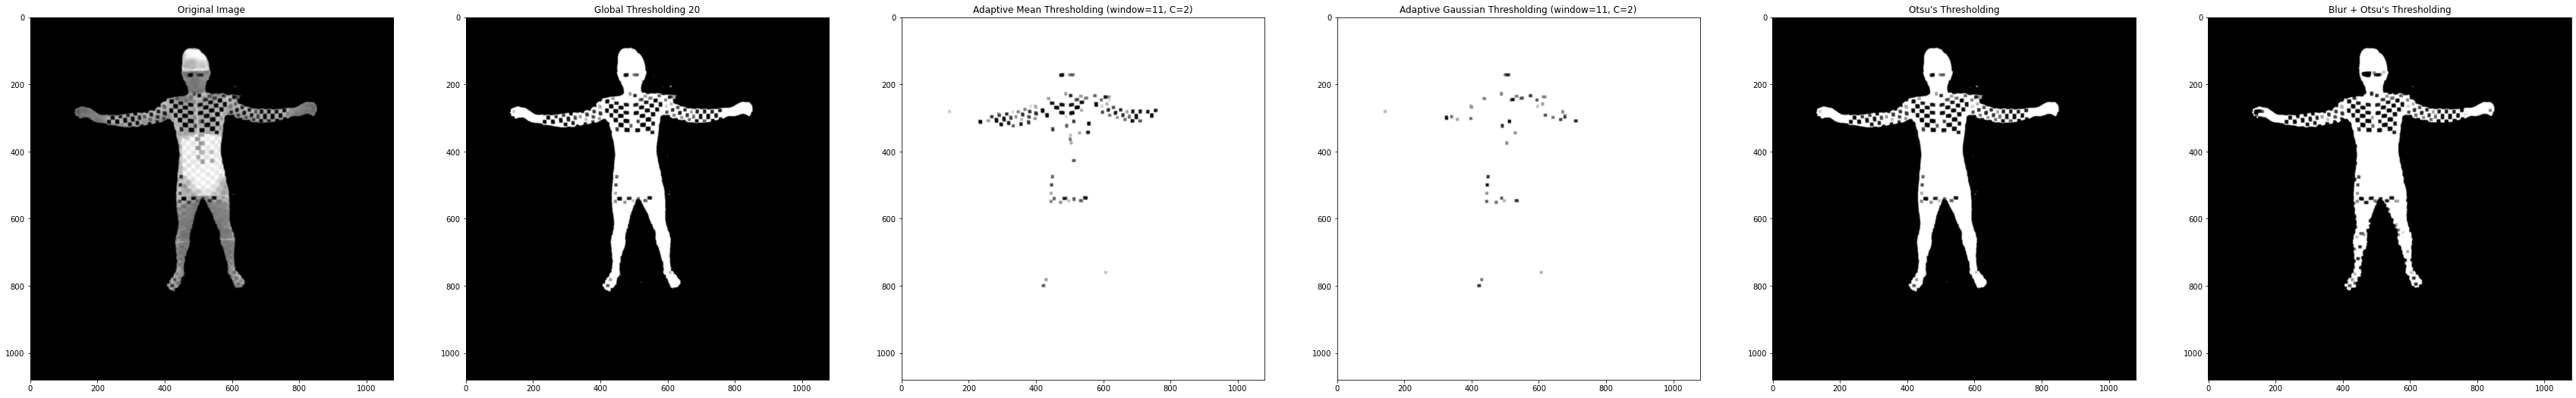

In [205]:
dilate_erodes = []
kernel = np.ones((3,3), np.uint8)
for i in range(len(images)):
    img = images[i]
    
    img = cv2.dilate(img, kernel, iterations=3)
#     img = cv2.medianBlur(img, 3)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.erode(img, kernel, iterations=3)
    dilate_erodes.append(img)
#     images[i] = img

fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 20))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(dilate_erodes[i], cmap='gray')
    ax[i].set_title(titles[i])
plt.show()

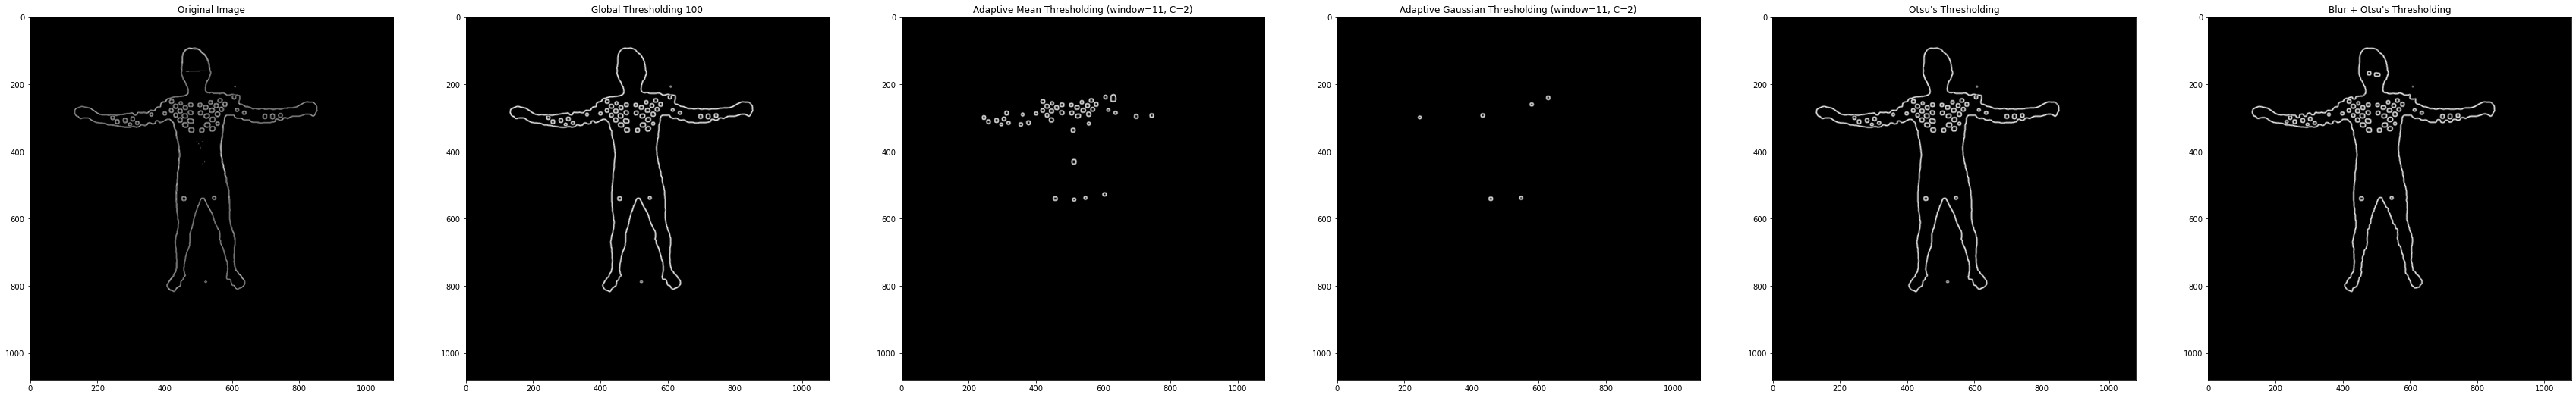

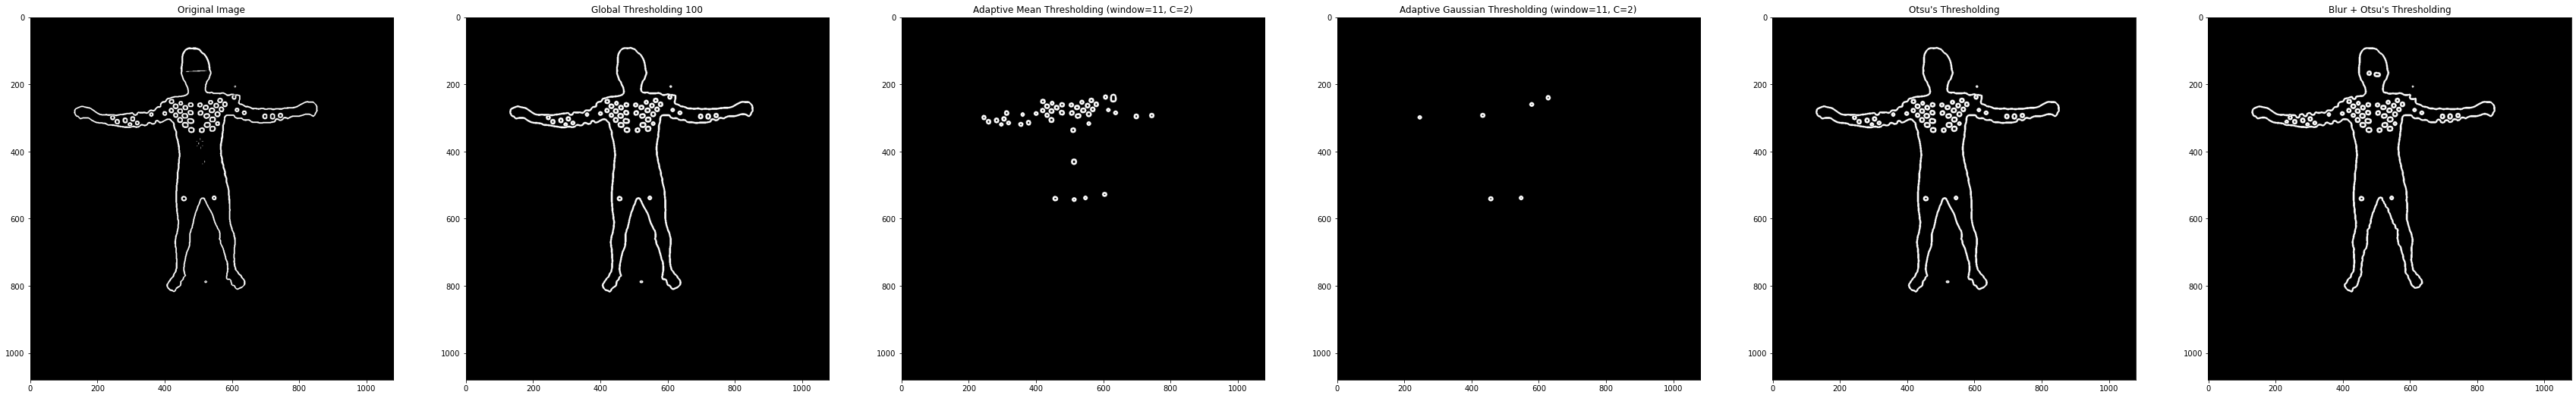

In [184]:
import numpy as np
import cv2
def edgedetect(channel):
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255; # Some values seem to go above 255. However RGB channels has to be within 0-255
    return sobel

edges = []
edges2 = [] # for comparisons
for i in range(len(images)):
    img = images[i]
    blurred = cv2.GaussianBlur(img, (7, 7), 0)
    blurred_float = blurred.astype(np.float32) / 255.0
    blurred_float = np.dstack([blurred_float, blurred_float, blurred_float])

#     edgeDetector = cv2.ximgproc.createStructuredEdgeDetection(r"D:\1_Projects\200325_PyTorch3d_Toy\17_data\input\model.yml")
#     edge = edgeDetector.detectEdges(blurred_float) * 255.0

    edge_r = edgedetect(blurred_float[:,:, 0])
    edge_g = edgedetect(blurred_float[:,:, 1])
    edge_b = edgedetect(blurred_float[:,:, 2])
    edge = np.max(np.dstack([edge_r, edge_g, edge_b]), axis=2)
    edges.append(edge.copy())
    
    mean = np.mean(edge)
    # Zero any value that is less than mean. This reduces a lot of noise.
    edge[edge <= mean] = 0
    edge[edge > mean] = 1.0
    edges2.append(edge)

fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 20))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(edges[i], cmap='gray')
    ax[i].set_title(titles[i])
plt.show()

fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 20))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(edges2[i], cmap='gray')
    ax[i].set_title(titles[i])
plt.show()

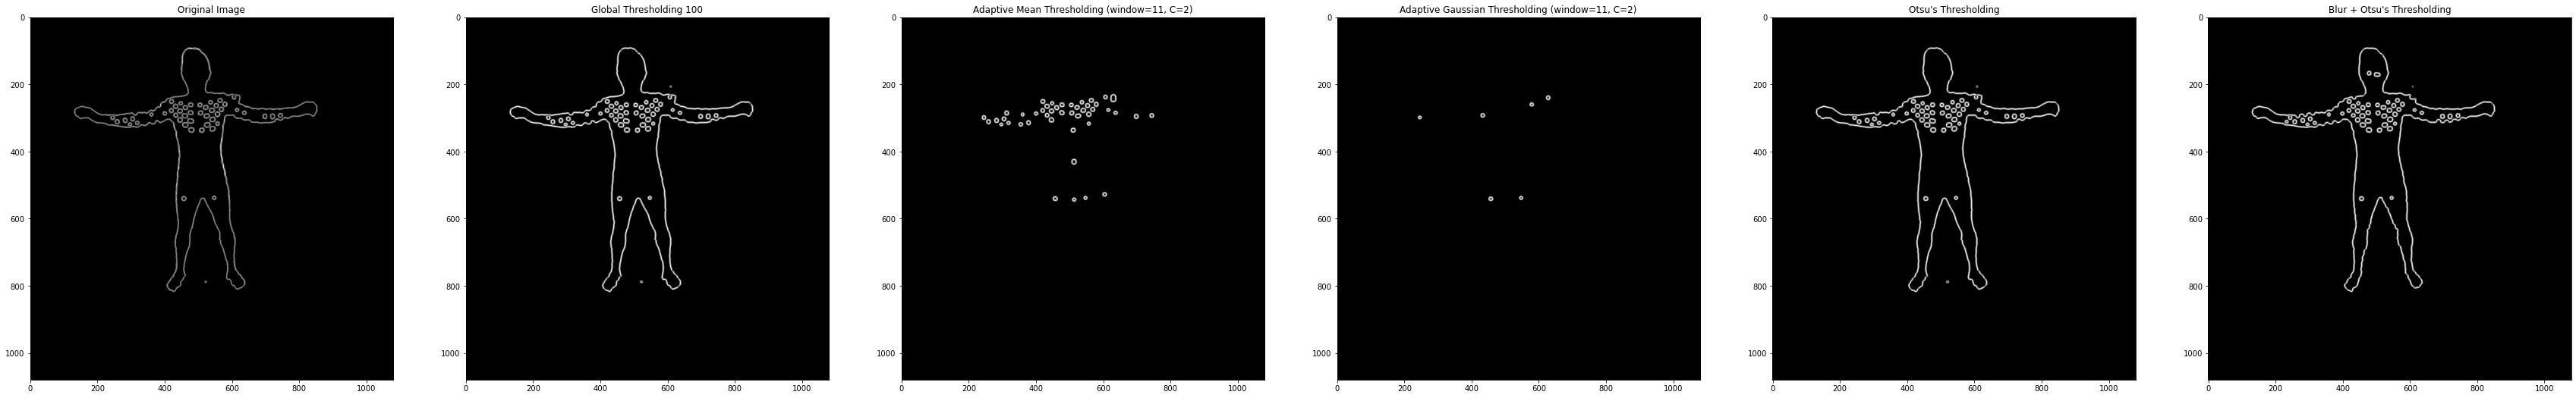

In [185]:
def filterOutSaltPepperNoise(edgeImg):
    # Get rid of salt & pepper noise.
    count = 0
    lastMedian = edgeImg
    median = cv2.medianBlur(edgeImg, 3)
    while not np.array_equal(lastMedian, median):
        # get those pixels that gets zeroed out
        zeroed = np.invert(np.logical_and(median, edgeImg))
        edgeImg[zeroed] = 0

        count = count + 1
        if count > 70:
            break
        lastMedian = median
        median = cv2.medianBlur(edgeImg, 3)
        
edges_8u = []
for i in range(len(edges)):
    edge = edges[i]
    edge_8u = np.asarray(edge, np.uint8)
    filterOutSaltPepperNoise(edge_8u)
    
#     edge_8u = cv2.erode(edge_8u, kernel, iterations=1)
#     edge_8u = cv2.medianBlur(edge_8u, 3)
#     edge_8u = cv2.dilate(edge_8u, kernel, iterations=1)

    edges_8u.append(edge_8u)
    
    
fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 10))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(edges_8u[i], cmap='gray')
    ax[i].set_title(titles[i])
plt.show()

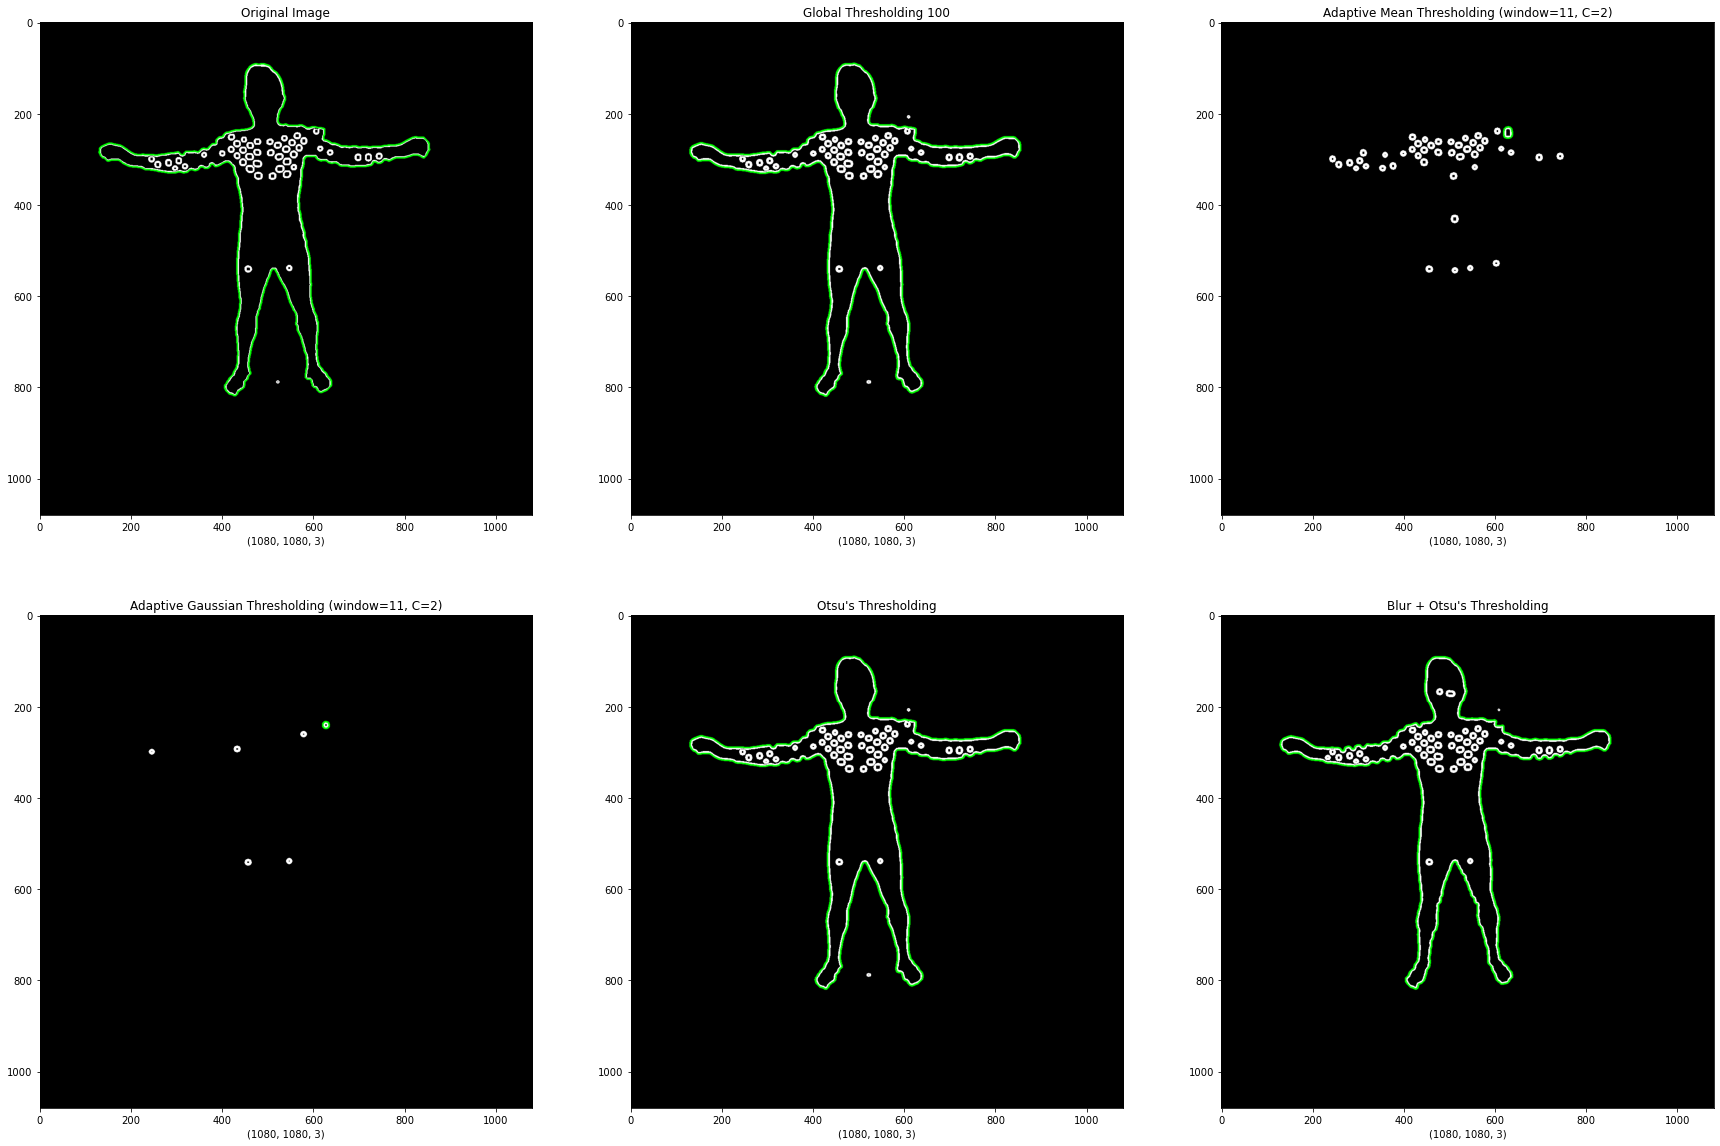

In [186]:
from scipy.interpolate import splprep, splev

def findSignificantContour(edgeImg):
    # input: an 8-bit single-channel image
    """
    CV_RETR_TREE: retrieves all of the contours and reconstructs a full hierarchy of nested contours. 
    
    
    """
    contours, hierarchy = cv2.findContours(
        edgeImg,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
     # Find level 1 contours
    level1Meta = []
    for contourIndex, tupl in enumerate(hierarchy[0]):
        # Each array is in format (Next, Prev, First child, Parent)
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl.copy(), 0, [contourIndex])
            level1Meta.append(tupl)
     # From among them, find the contours with large surface area.
    contoursWithArea = []
    for tupl in level1Meta:
        contourIndex = tupl[0]
        contour = contours[contourIndex]
        area = cv2.contourArea(contour)
        contoursWithArea.append([contour, area, contourIndex])
    contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
    largestContour = contoursWithArea[0][0]
    return largestContour

contour_imgs = []
contours = []
for i in range(len(edges_8u)):
    edge_8u = edges_8u[i]*255
    contour = findSignificantContour(edge_8u)
    contours.append(contour)
    
    # Draw the contour on the original image
    contourImg = np.copy(edge_8u)
    contourImg = np.dstack([contourImg, contourImg, contourImg])
    cv2.drawContours(contourImg, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)
    contour_imgs.append(contourImg)

    
fig, ax = plt.subplots(2, len(images) // 2, figsize=(5*len(images), 20))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(contour_imgs[i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(contour_imgs[i].shape)
plt.show()

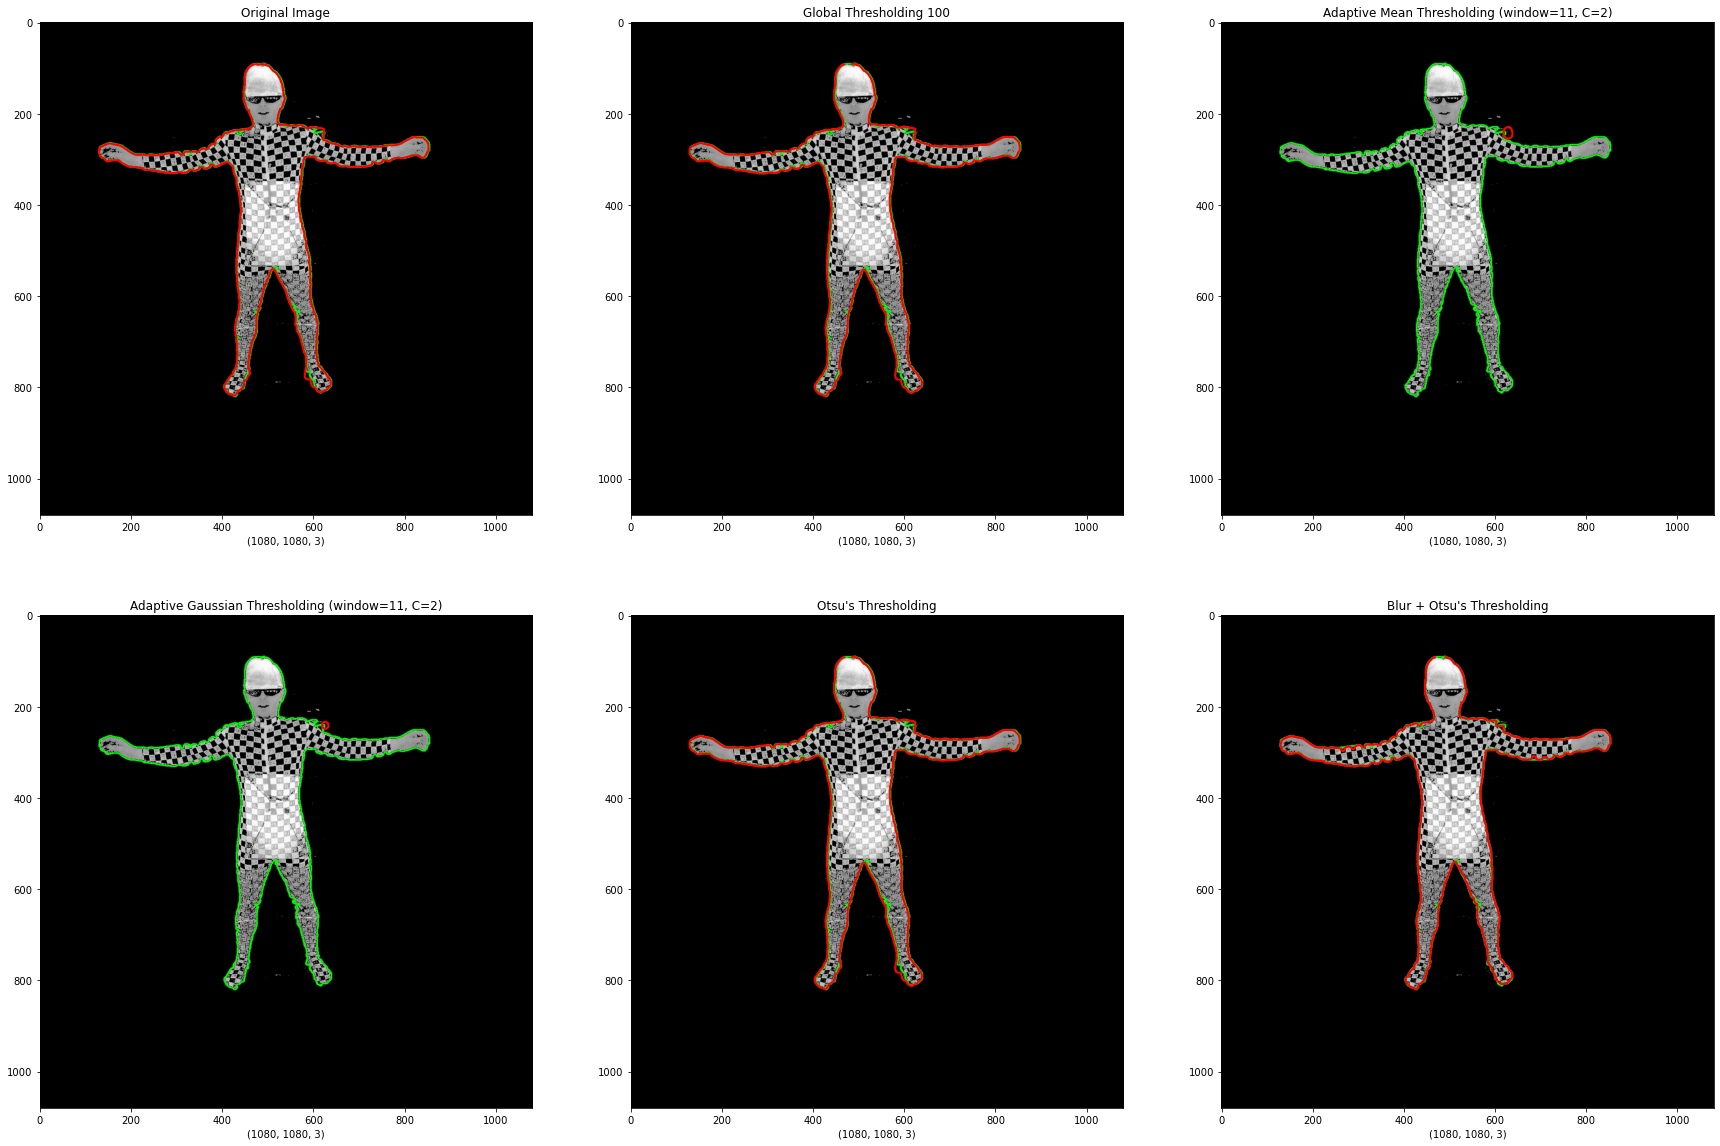

In [187]:
cnt_approx = []
for i in range(len(edges_8u)):
    cnt = contours[i]
    epsilon = 0.00001*cv2.arcLength(cnt, True)
    app = cv2.approxPolyDP(cnt, epsilon, True)
    cnt_approx.append(app)

fig, ax = plt.subplots(2, len(images) // 2, figsize=(5*len(images), 20))
ax = ax.ravel()
for i in range(len(ax)):
    app = cnt_approx[i].squeeze()
    ax[i].imshow(contour_img)
    ax[i].plot(app[:, 0], app[:, 1], '-r', lw=2)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(contour_imgs[i].shape)

### snake

In [133]:
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour


snake_inits = []
snakes = []
contour_centers = []
for i in range(len(edges_8u)):
    print('  {}/{}'.format(i+1, len(edges_8u)), end='')
    contour = contours[i].squeeze().astype(np.float32)
    center = np.mean(contour, axis=0)
    contour_centers.append(center)
    radius = np.max(np.abs(contour - center)) * 1.1
    
    s = np.linspace(0, 2*np.pi, 100)
    r = center[1] + radius*np.sin(s)
    c = center[0] + radius*np.cos(s)
    snake_init = np.array([r, c]).T
    snake_inits.append(snake_init)
    
    snake = active_contour(edge_8u, snake_init, alpha=0.001, beta=0.00001, gamma=0.001, coordinates='rc')
    snakes.append(snake)
    if i > 0:
        break
print('\nDone')

  1/6  2/6
Done


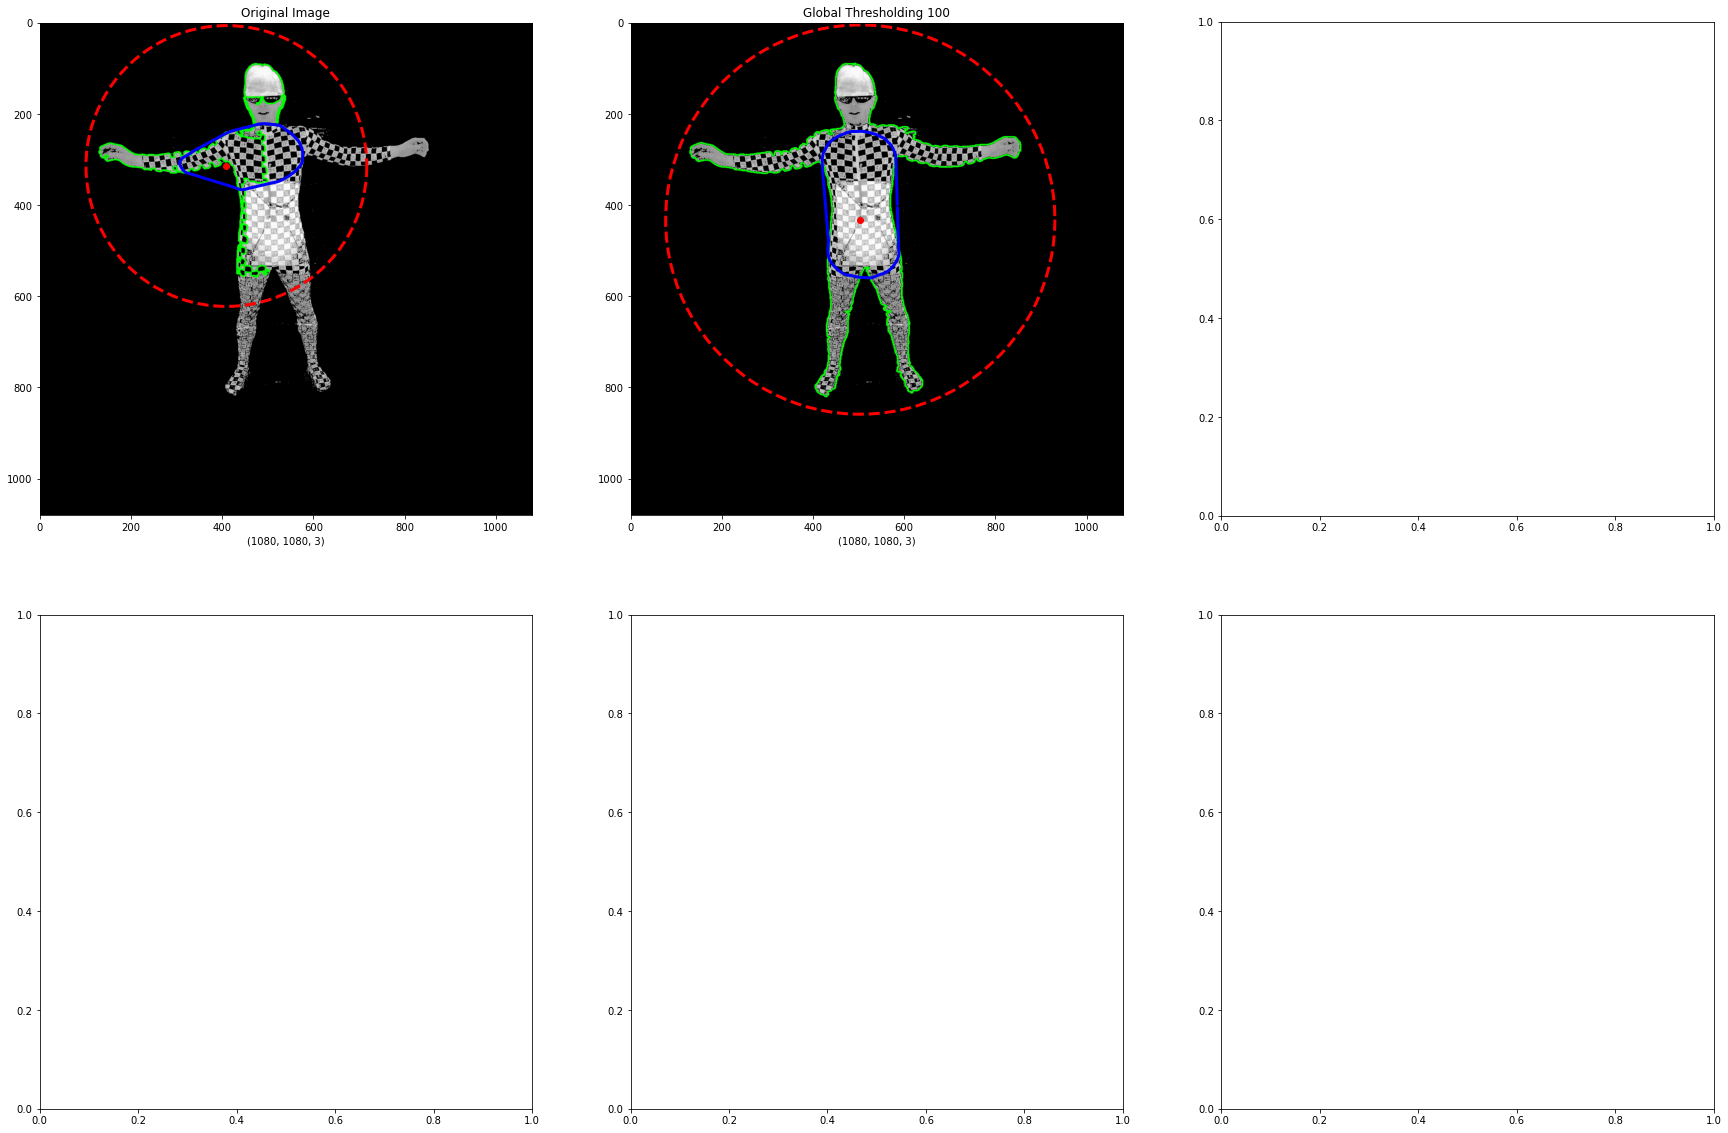

In [134]:
fig, ax = plt.subplots(2, len(images) // 2, figsize=(5*len(images), 20))
ax = ax.ravel()
for i in range(len(ax)):
    contour_img = contour_imgs[i]
    snake = snakes[i]
    init = snake_inits[i]
    center = contour_centers[i]
    ax[i].imshow(contour_img)
    ax[i].plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax[i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax[i].scatter(center[0], center[1], c='r')
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(contour_imgs[i].shape)
    if i > 0:
        break
plt.show()

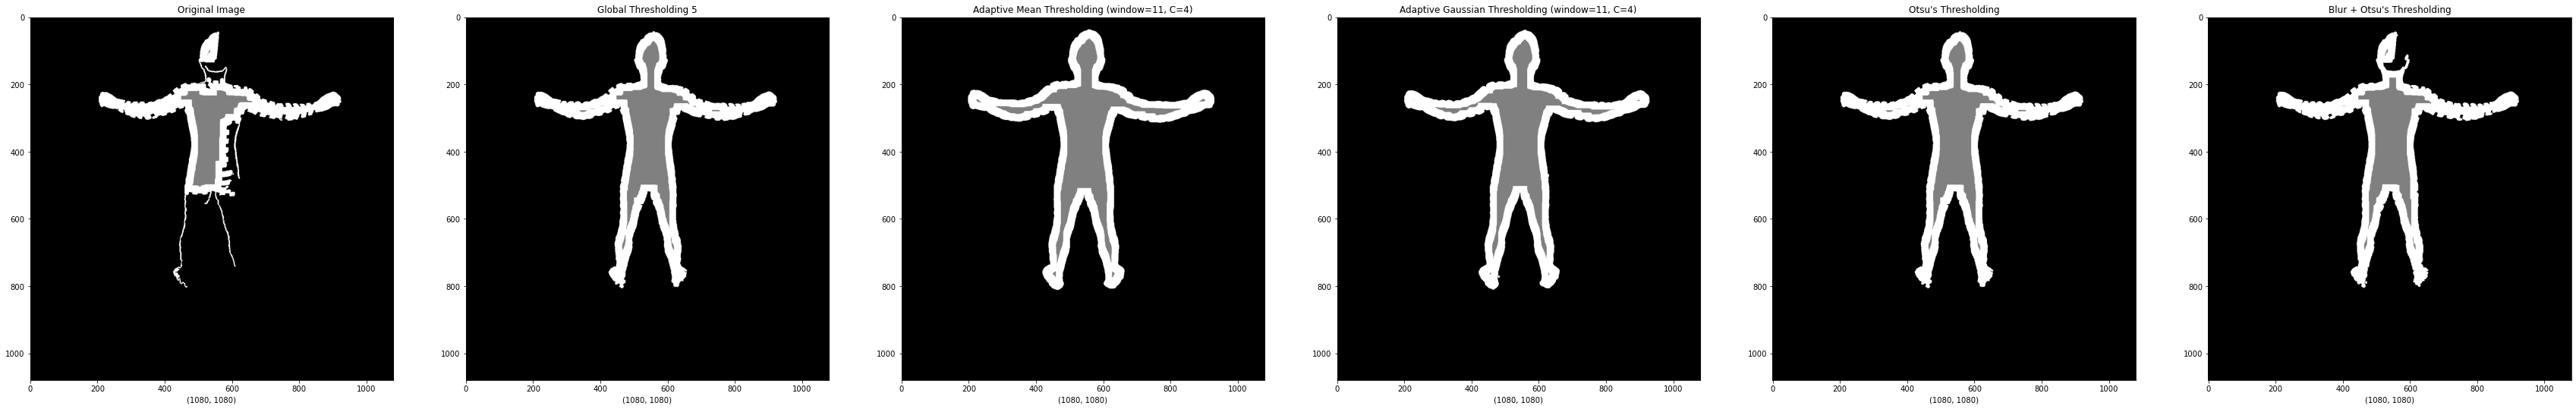

In [44]:
trimaps = []
masks = []
for i in range(len(edges_8u)):
    edge_8u = edges_8u[i]
    mask = np.zeros_like(edge_8u)

    contour = contours[i]
    cv2.fillPoly(mask, [contour], 255)

    # calculate sure foreground area by dilating the mask
    mapFg = cv2.erode(mask, np.ones((5, 5), np.uint8), iterations=10)

    # mark inital mask as "probably background"
    # and mapFg as sure foreground
    trimap = np.copy(mask)
    trimap[mask == 0] = cv2.GC_BGD
    trimap[mask == 255] = cv2.GC_PR_BGD
    trimap[mapFg == 255] = cv2.GC_FGD

    # visualize trimap
    trimap_print = np.copy(trimap)
    trimap_print[trimap_print == cv2.GC_PR_BGD] = 128
    trimap_print[trimap_print == cv2.GC_FGD] = 255
    trimaps.append(trimap)
    masks.append(mask)

fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 10))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(trimaps[i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(trimaps[i].shape)
plt.show()

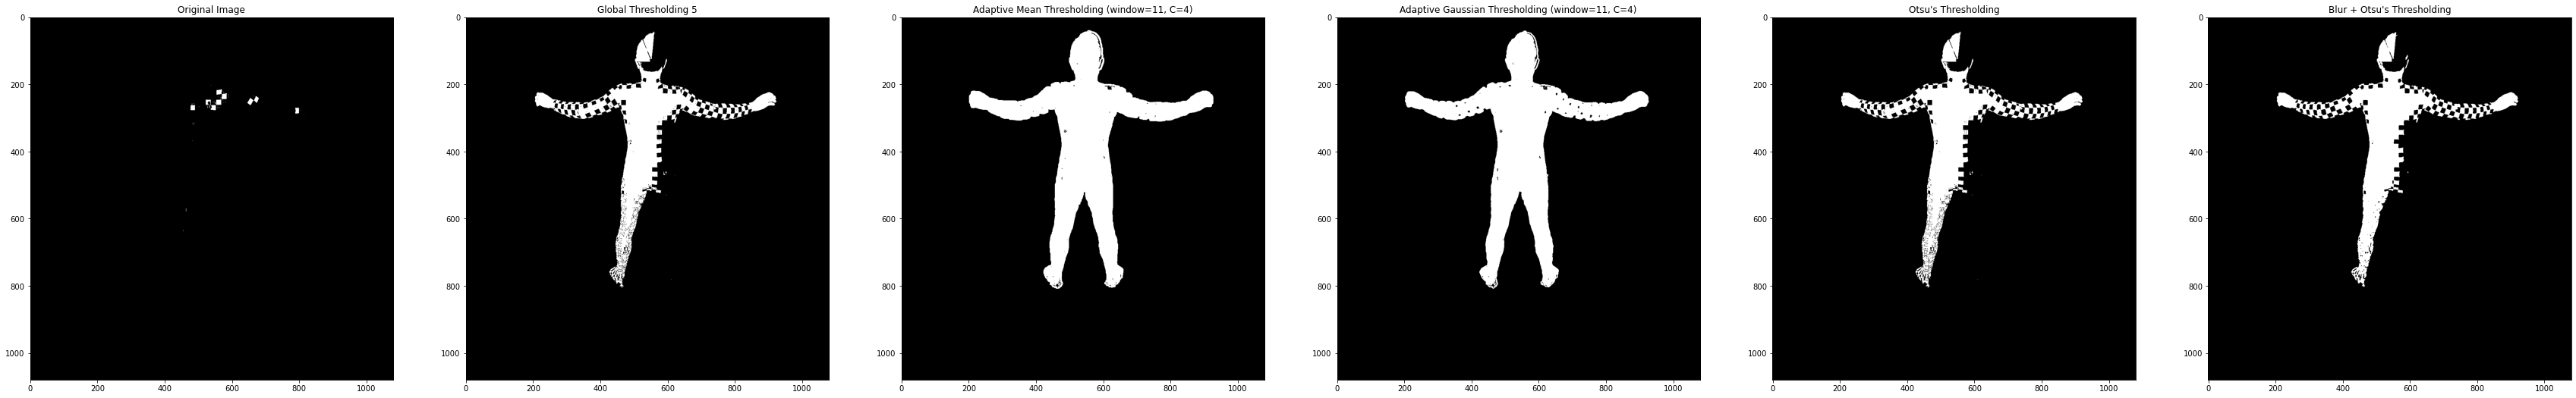

In [320]:
# run grabcut
grabcuts = []
for i in range(len(trimaps)):
    src1 = images[i].astype(np.uint8)
    src1 = np.dstack([src1, src1, src1])
    trimap = trimaps[i]
    mask2 = masks[i]
    
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, mask2.shape[0] - 1, mask2.shape[1] - 1)
    cv2.grabCut(src1, trimap, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)

    # create mask again
    mask3 = np.where(
        (trimap == cv2.GC_FGD) | (trimap == cv2.GC_PR_FGD),
        255,
        0
    ).astype('uint8')
    grabcuts.append(mask3)

fig, ax = plt.subplots(1, len(images), figsize=(10*len(images), 10))
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(grabcuts[i], cmap='gray')
    ax[i].set_title(titles[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


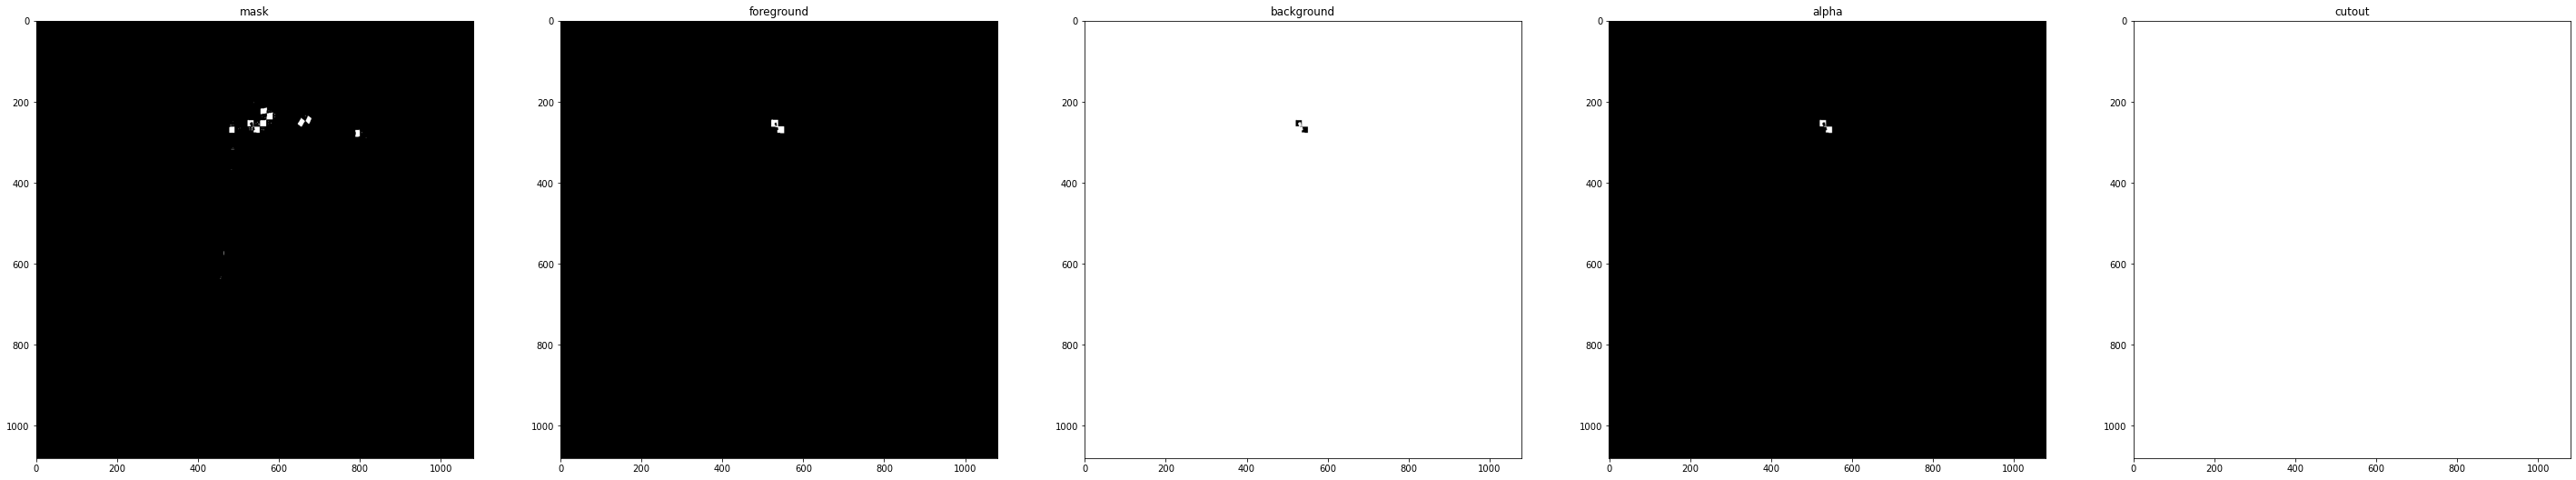

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


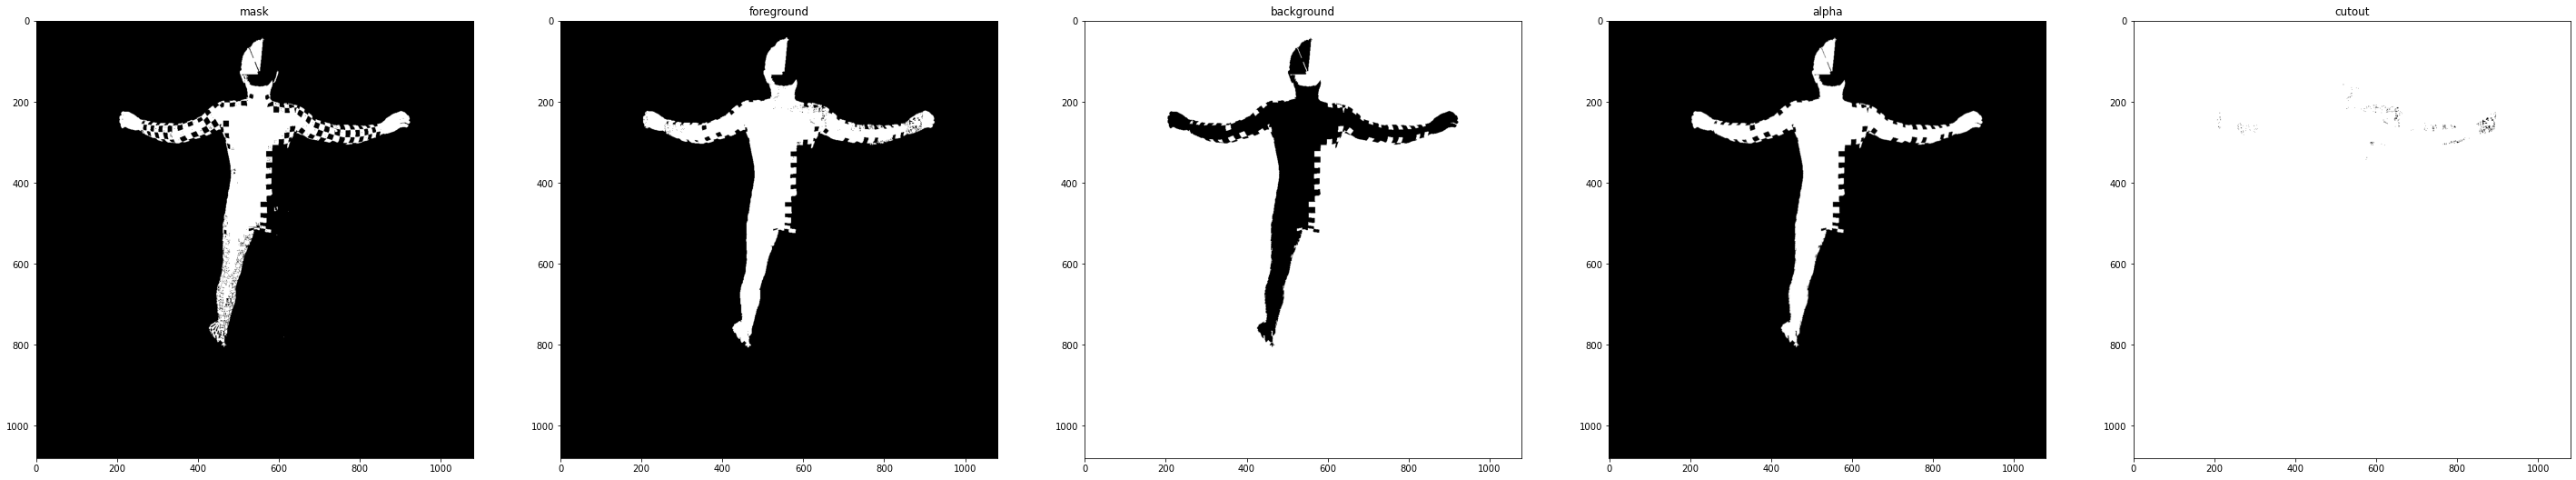

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


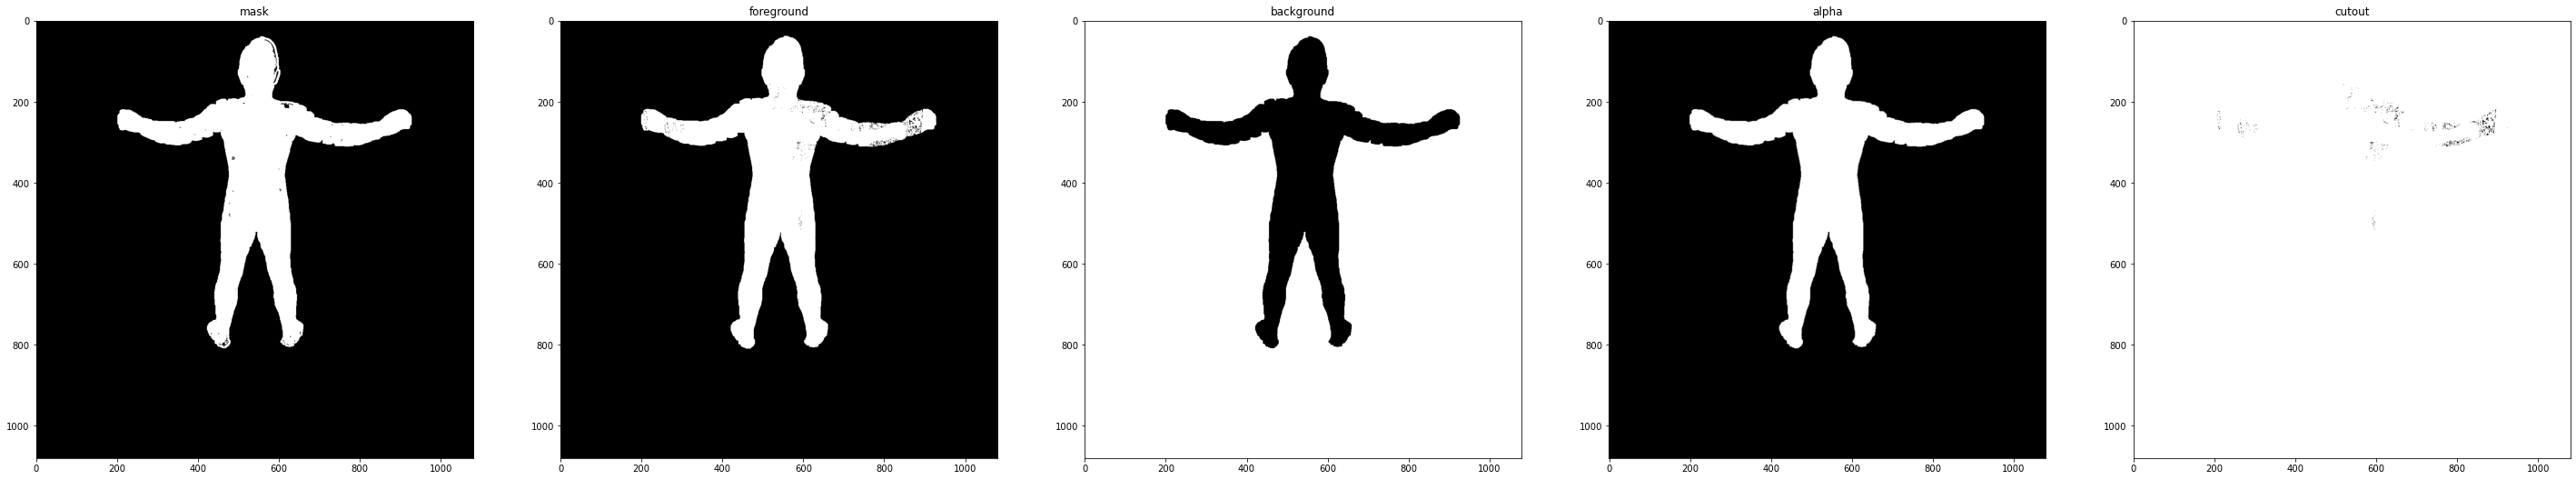

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


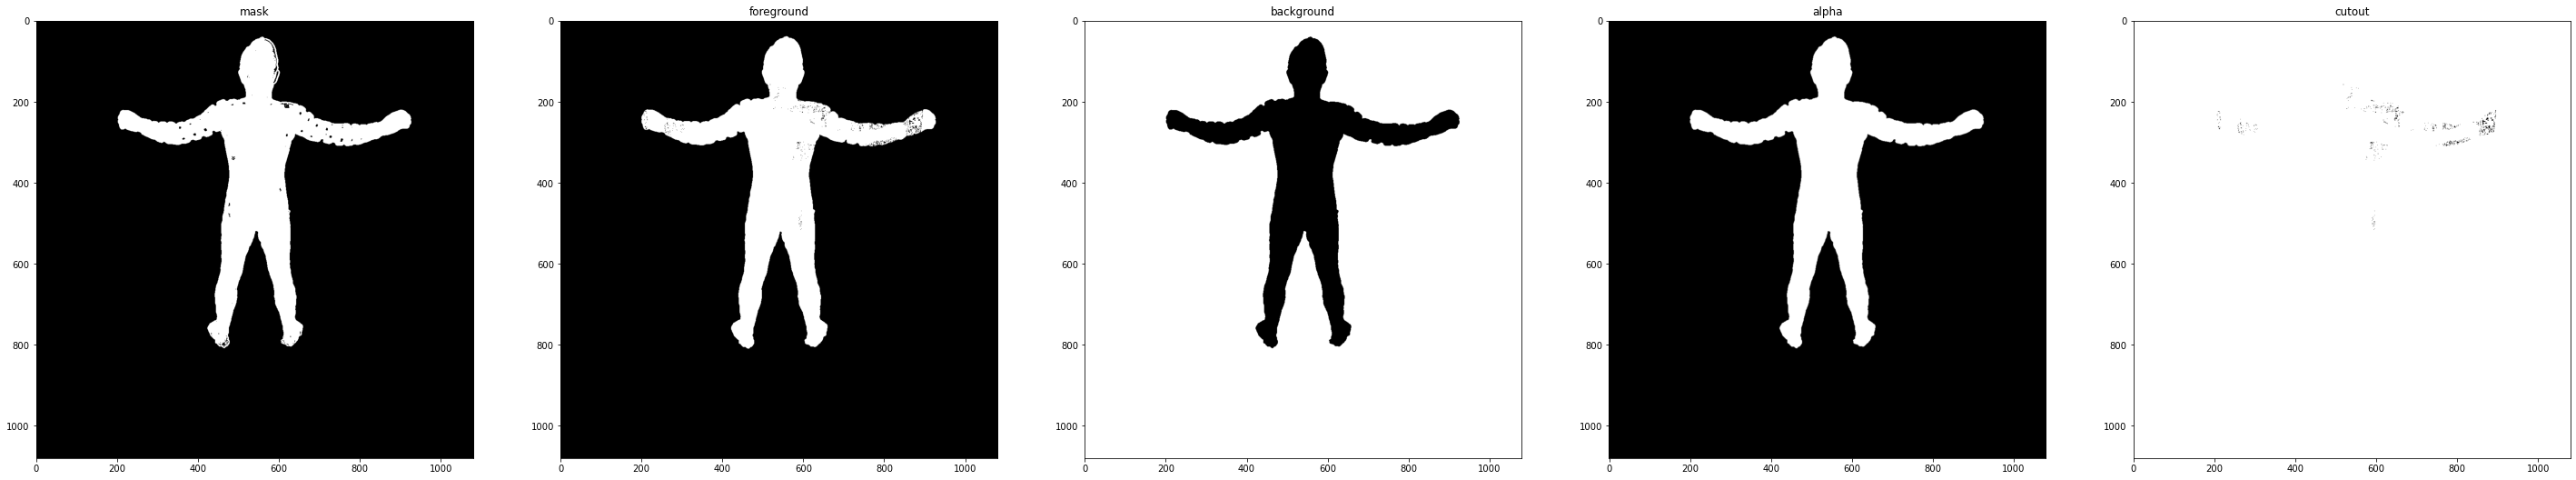

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


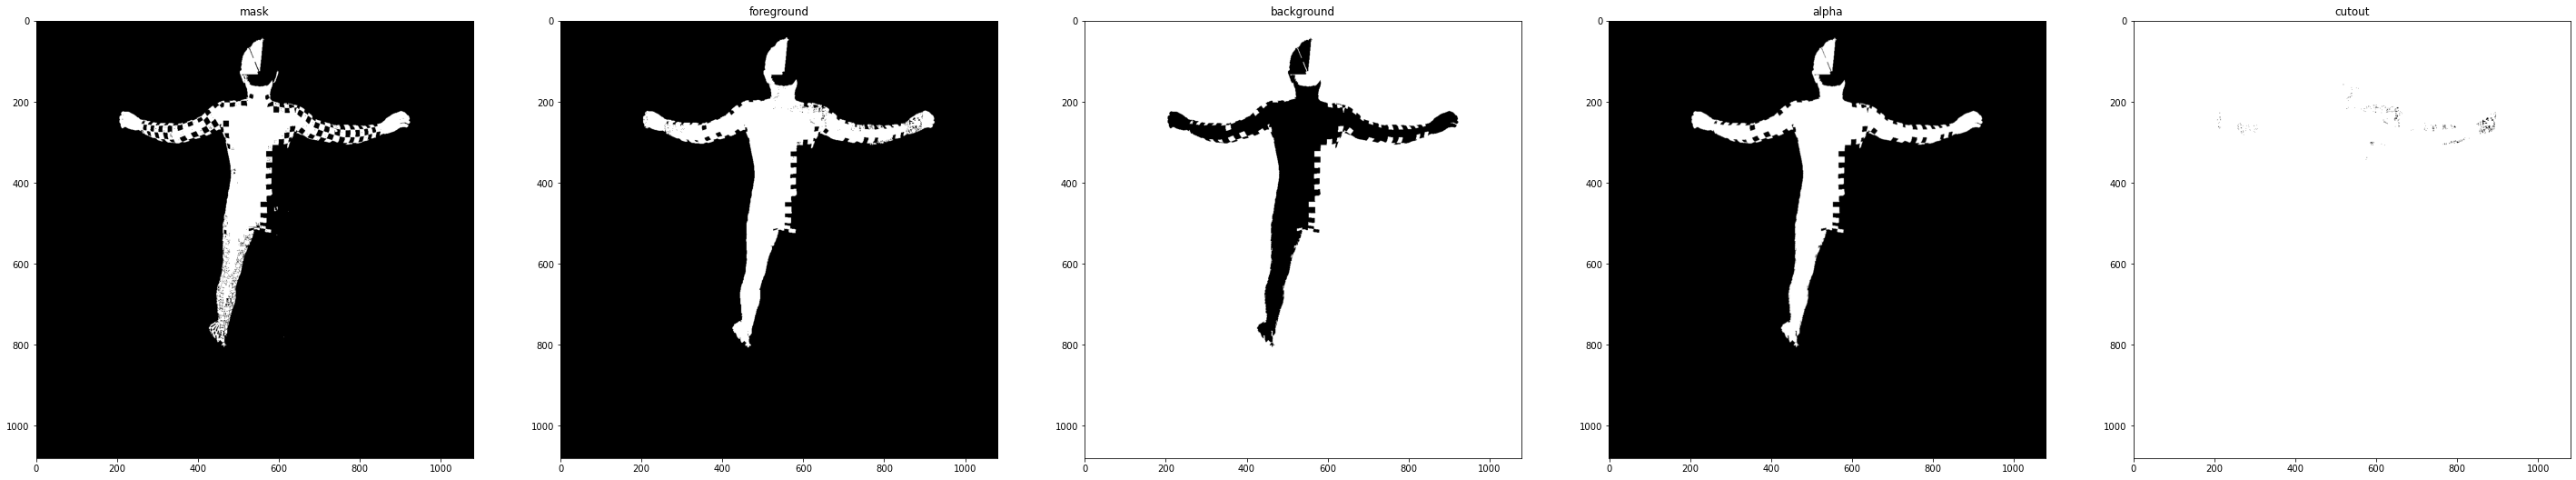

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


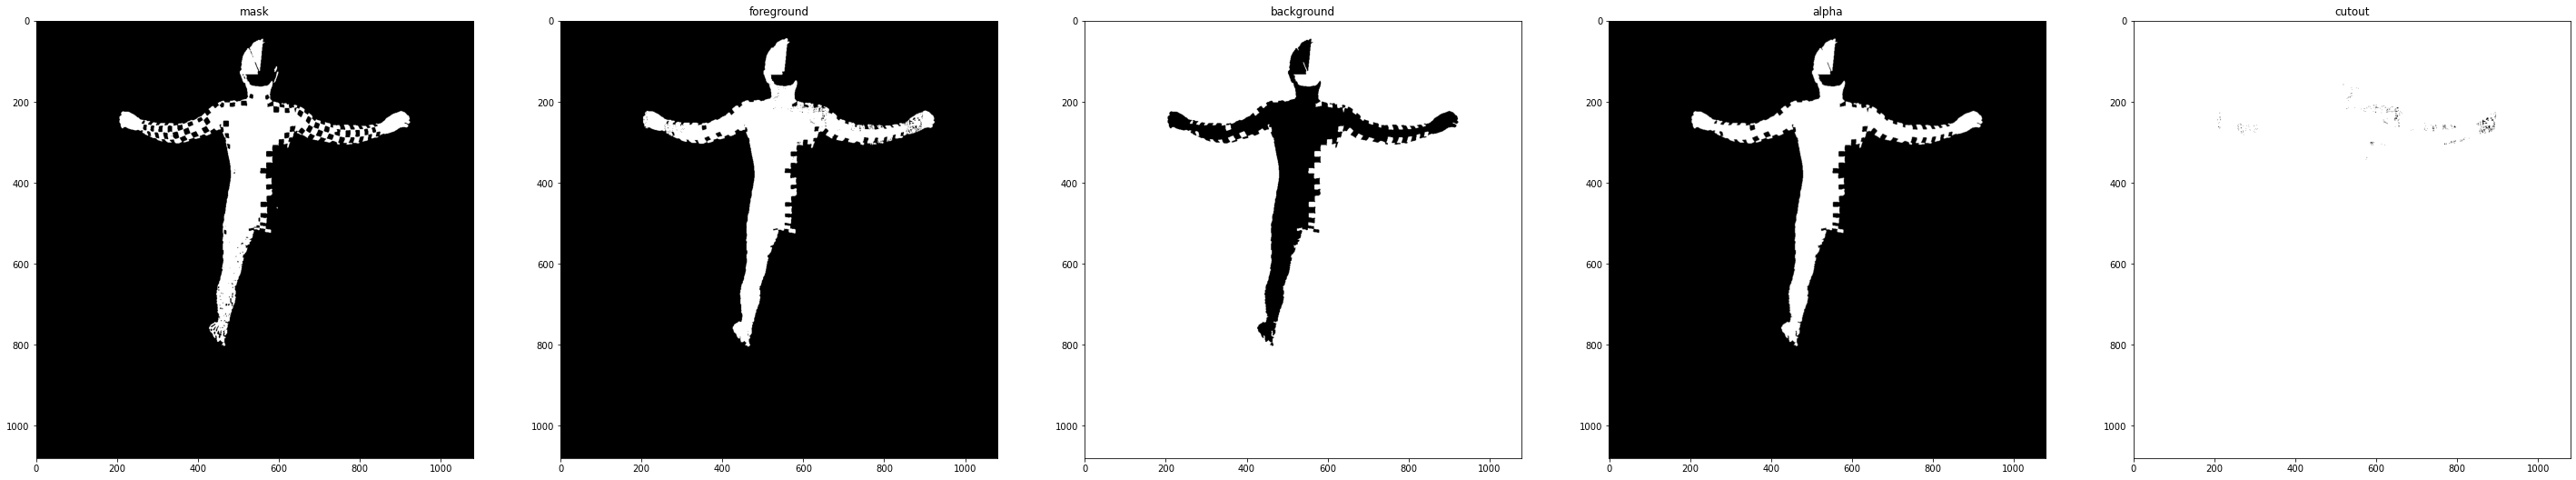

In [321]:
fgs = []
bgs = []
alphas = []
cutouts = []

for i in range(len(grabcuts)):
    mask = grabcuts[i]
    contour = findSignificantContour(mask)
    mask3 = np.zeros_like(mask)
    cv2.fillPoly(mask3, [contour], 255)
    
    # blended alpha cut-out
    mask3 = np.repeat(mask3[:, :, np.newaxis], 3, axis=2)
    mask4 = cv2.GaussianBlur(mask3, (3, 3), 0)
    alpha = mask4.astype(float) * 1.1  # making blend stronger
    alpha[mask3 > 0] = 255
    alpha[alpha > 255] = 255
    alpha = alpha.astype(float)

    foreground = np.copy(src).astype(float)
    foreground[mask4 == 0] = 0
    background = np.ones_like(foreground, dtype=float) * 255

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha / 255.0
    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)
    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)
    # Add the masked foreground and background.
    cutout = cv2.add(foreground, background)

    fgs.append(foreground)
    bgs.append(background)
    alphas.append(alpha)
    cutouts.append(cutout)

for i in range(len(cutouts)):
    fig, ax = plt.subplots(1, 5, figsize=(50, 10))
    ax[0].imshow(grabcuts[i], cmap='gray')
    ax[0].set_title('mask')
    
    ax[1].imshow(fgs[i], cmap='gray')
    ax[1].set_title('foreground')
    
    ax[2].imshow(bgs[i], cmap='gray')
    ax[2].set_title('background')
    
    ax[3].imshow(alphas[i], cmap='gray')
    ax[3].set_title('alpha')
    
    ax[4].imshow(cutouts[i], cmap='gray')
    ax[4].set_title('cutout')
    plt.show()